In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
torch.__version__
import numpy as np
from plot import plot_loss_and_acc

In [37]:
# 超参数
BATCH_SIZE=512 #大概需要2G的显存
EPOCHS=10 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU，建议使用GPU环境，因为会快很多
print(DEVICE)

cpu


In [38]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

In [39]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

In [40]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 5) # 输入通道数1，输出通道数10，核的大小5
        self.conv2 = nn.Conv2d(10, 20, 3) # 输入通道数10，输出通道数20，核的大小3
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(20*10*10, 500) # 输入通道数是2000，输出通道数是500
        self.fc2 = nn.Linear(500, 10) # 输入通道数是500，输出通道数是10，即10分类
    def forward(self,x):
        in_size = x.size(0) # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。
        out = self.conv1(x) # batch*1*28*28 -> batch*10*24*24（28x28的图像经过一次核为5x5的卷积，输出变为24x24）
        out = F.relu(out) # batch*10*24*24（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2) # batch*10*24*24 -> batch*10*12*12（2*2的池化层会减半）
        out = self.conv2(out) # batch*10*12*12 -> batch*20*10*10（再卷积一次，核的大小是3）
        out = F.relu(out) # batch*20*10*10
        out = out.view(in_size, -1) # batch*20*10*10 -> batch*2000（out的第二维是-1，说明是自动推算，本例中第二维是20*10*10）
        out = self.fc1(out) # batch*2000 -> batch*500
        out = F.relu(out) # batch*500
        out = self.fc2(out) # batch*500 -> batch*10
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x))
        return out

In [41]:
class MLPNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392,128)
        self.fc3 = nn.Linear(128,10)
    def forward(self, x):
        in_size = x.size(0)
        out = x.view(in_size, -1)
        out = self.fc1(out)
        out =  F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [42]:
def train_one_epoch(model, device, train_loader, optimizer, epoch):
    batch_train_loss, batch_train_acc = [], []
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
        _, predicted = torch.max(output, 1)
        corr = (predicted == target).sum().item()
        loss.backward()
        optimizer.step()
        correct += corr
        total += target.size(0)

        if(batch_idx+1)%30 == 0: 
            acc = 1.000 * correct/total
            # print('correct:',correct, 'total:', total , 'acc:', acc)
            batch_train_acc.append(acc)
            batch_train_loss.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tACC: {:.6f}'.format(
                epoch, total, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), acc))
    return batch_train_loss, batch_train_acc

def train(model, device, train_loader, optimizer, epoch):
    avg_batch_train_loss, avg_batch_train_acc = [], []
    for ep in range(1, epoch + 1):
        batch_train_loss,batch_train_acc = train_one_epoch(model, device, train_loader, optimizer, ep)
        avg_batch_train_loss.append(np.mean(batch_train_loss))
        avg_batch_train_acc.append(np.mean(batch_train_acc))
    return model, avg_batch_train_loss, avg_batch_train_loss

In [43]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [44]:
# CNN 模型
cnn_model = ConvNet().to(DEVICE)
optimizer = optim.Adam(cnn_model.parameters())

In [45]:
# 训练CNN模型
cnn_model, cnn_loss, cnn_acc = train(cnn_model, DEVICE, train_loader, optimizer, EPOCHS)
test(cnn_model, DEVICE, test_loader)

Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.257578	ACC: 0.812044
Train Epoch: 1 [30720/60000 (50%)]	Loss: 0.215916	ACC: 0.868359
Train Epoch: 1 [46080/60000 (75%)]	Loss: 0.165396	ACC: 0.894293
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.116744	ACC: 0.967643
Train Epoch: 2 [30720/60000 (50%)]	Loss: 0.061666	ACC: 0.971029
Train Epoch: 2 [46080/60000 (75%)]	Loss: 0.080923	ACC: 0.972786
Train Epoch: 3 [15360/60000 (25%)]	Loss: 0.038066	ACC: 0.984896
Train Epoch: 3 [30720/60000 (50%)]	Loss: 0.050616	ACC: 0.984603
Train Epoch: 3 [46080/60000 (75%)]	Loss: 0.047337	ACC: 0.983963
Train Epoch: 4 [15360/60000 (25%)]	Loss: 0.062809	ACC: 0.988932
Train Epoch: 4 [30720/60000 (50%)]	Loss: 0.062258	ACC: 0.989323
Train Epoch: 4 [46080/60000 (75%)]	Loss: 0.041295	ACC: 0.989453
Train Epoch: 5 [15360/60000 (25%)]	Loss: 0.028056	ACC: 0.988737
Train Epoch: 5 [30720/60000 (50%)]	Loss: 0.020263	ACC: 0.989681
Train Epoch: 5 [46080/60000 (75%)]	Loss: 0.020963	ACC: 0.990321
Train Epoch: 6 [15360/60000 (25%)]	Loss:

In [46]:
# MLP 模型
mlp_model = MLPNet().to(DEVICE)
mlp_optimizer = optim.Adam(mlp_model.parameters())

In [47]:
# 训练MLP模型
mlp_model, mlp_loss, mlp_acc = train(mlp_model, DEVICE, train_loader, mlp_optimizer, EPOCHS)
test(mlp_model, DEVICE, test_loader)

Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.435049	ACC: 0.797070
Train Epoch: 1 [30720/60000 (50%)]	Loss: 0.387683	ACC: 0.852930
Train Epoch: 1 [46080/60000 (75%)]	Loss: 0.177139	ACC: 0.876172
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.160911	ACC: 0.950000
Train Epoch: 2 [30720/60000 (50%)]	Loss: 0.149326	ACC: 0.951986
Train Epoch: 2 [46080/60000 (75%)]	Loss: 0.104780	ACC: 0.953429
Train Epoch: 3 [15360/60000 (25%)]	Loss: 0.096406	ACC: 0.971224
Train Epoch: 3 [30720/60000 (50%)]	Loss: 0.089391	ACC: 0.970671
Train Epoch: 3 [46080/60000 (75%)]	Loss: 0.099630	ACC: 0.971419
Train Epoch: 4 [15360/60000 (25%)]	Loss: 0.053730	ACC: 0.977799
Train Epoch: 4 [30720/60000 (50%)]	Loss: 0.073967	ACC: 0.978092
Train Epoch: 4 [46080/60000 (75%)]	Loss: 0.050257	ACC: 0.979058
Train Epoch: 5 [15360/60000 (25%)]	Loss: 0.032567	ACC: 0.985091
Train Epoch: 5 [30720/60000 (50%)]	Loss: 0.036959	ACC: 0.984147
Train Epoch: 5 [46080/60000 (75%)]	Loss: 0.053630	ACC: 0.984201
Train Epoch: 6 [15360/60000 (25%)]	Loss:

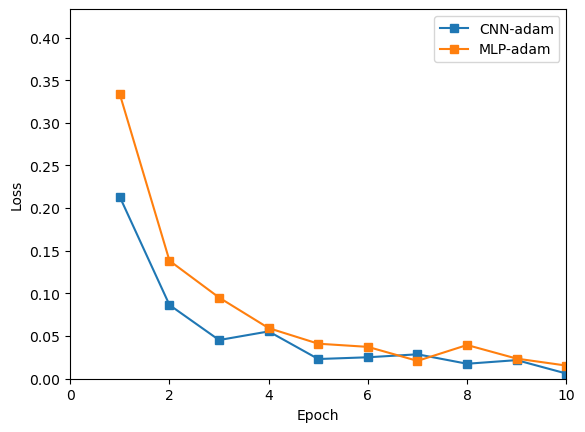

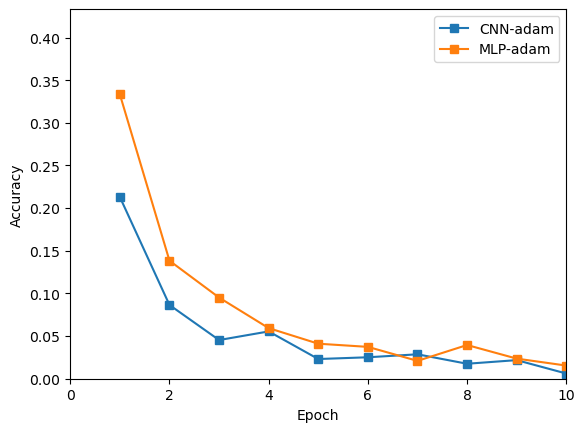

In [49]:
plot_loss_and_acc({'CNN-adam': [cnn_loss, cnn_acc],
                   'MLP-adam': [mlp_loss, mlp_acc]})

In [ ]:
# 一个卷积层，一个pooling，两个全连接层
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 5) # 输入通道数1，输出通道数10，核的大小5
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(10*12*12, 500) # 输入通道数是1440，输出通道数是500
        self.fc2 = nn.Linear(500, 10) # 输入通道数是500，输出通道数是10，即10分类
    def forward(self,x):
        in_size = x.size(0) # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。
        out = self.conv1(x) # batch*1*28*28 -> batch*10*24*24（28x28的图像经过一次核为5x5的卷积，输出变为24x24）
        out = F.relu(out) # batch*10*24*24（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2) # batch*10*24*24 -> batch*10*12*12（2*2的池化层会减半）
        out = out.view(in_size, -1) # batch*10*12*12 -> batch*1440（out的第二维是-1，说明是自动推算，本例中第二维是10*12*12）
        out = self.fc1(out) # batch*1440 -> batch*500
        out = F.relu(out) # batch*500
        out = self.fc2(out) # batch*500 -> batch*10
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x))
        return out

In [ ]:
# 卷积核变大

class ConvNet3(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 5) # 输入通道数1，输出通道数10，核的大小5
        # self.conv2 = nn.Conv2d(10, 20, 3) # 输入通道数10，输出通道数20，核的大小3
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(20*10*10, 500) # 输入通道数是2000，输出通道数是500
        self.fc2 = nn.Linear(500, 10) # 输入通道数是500，输出通道数是10，即10分类
    def forward(self,x):
        in_size = x.size(0) # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。
        out = self.conv1(x) # batch*1*28*28 -> batch*10*24*24（28x28的图像经过一次核为5x5的卷积，输出变为24x24）
        out = F.relu(out) # batch*10*24*24（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2) # batch*10*24*24 -> batch*10*12*12（2*2的池化层会减半）
        out = self.conv2(out) # batch*10*12*12 -> batch*20*10*10（再卷积一次，核的大小是3）
        out = F.relu(out) # batch*20*10*10
        out = out.view(in_size, -1) # batch*20*10*10 -> batch*2000（out的第二维是-1，说明是自动推算，本例中第二维是20*10*10）
        out = self.fc1(out) # batch*2000 -> batch*500
        out = F.relu(out) # batch*500
        out = self.fc2(out) # batch*500 -> batch*10
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x))
        return out

In [ ]:
# 优化器 SGD

class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 5) # 输入通道数1，输出通道数10，核的大小5
        # self.conv2 = nn.Conv2d(10, 20, 3) # 输入通道数10，输出通道数20，核的大小3
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(20*10*10, 500) # 输入通道数是2000，输出通道数是500
        self.fc2 = nn.Linear(500, 10) # 输入通道数是500，输出通道数是10，即10分类
    def forward(self,x):
        in_size = x.size(0) # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。
        out = self.conv1(x) # batch*1*28*28 -> batch*10*24*24（28x28的图像经过一次核为5x5的卷积，输出变为24x24）
        out = F.relu(out) # batch*10*24*24（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2) # batch*10*24*24 -> batch*10*12*12（2*2的池化层会减半）
        out = self.conv2(out) # batch*10*12*12 -> batch*20*10*10（再卷积一次，核的大小是3）
        out = F.relu(out) # batch*20*10*10
        out = out.view(in_size, -1) # batch*20*10*10 -> batch*2000（out的第二维是-1，说明是自动推算，本例中第二维是20*10*10）
        out = self.fc1(out) # batch*2000 -> batch*500
        out = F.relu(out) # batch*500
        out = self.fc2(out) # batch*500 -> batch*10
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x))
        return out